In [ ]:
!pip install mlforecast
!pip install statsforecast
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, Naive, SeasonalNaive, SeasonalWindowAverage, AutoETS
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

import optuna
import pickle

import warnings
warnings.filterwarnings("ignore")

In [3]:
# фиксируем версию пакетов
!pip freeze > requirements.txt

## 1. Анализ и обработка данных

### Описание данных:

- pr_sku_id – захэшированное id товара
- date – дата
- pr_sales_type_id – флаг наличия промо
- pr_sales_in_units – число проданных товаров всего
- pr_promo_sales_in_units – число проданных товаров с признаком промо
- pr_sales_in_rub – продажи всего в РУБ
- pr_promo_sales_in_rub – продажи с признаком промо в РУБ

### 1.1 Обработка и очистка данных

In [5]:
df = pd.read_csv('data/sales_df.csv', parse_dates=['date'])

#объединяем обычные продажи с промо, оставляем при этом данные о промо продажах
cols_to_group = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']
df = df.groupby(['pr_sku_id','date'])[cols_to_group].sum().reset_index()

# удаляем отрицательные значения
df.loc[df['pr_sales_in_units'] < 0, ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']] = 0

In [6]:
# заменим захэшированный sku_id на более удобную для восприятия нумерацию для дальнейшего анализа и визуализации
# пронумеруем по объему продаж, запишем в словарь
sku_id_dict = df.groupby('pr_sku_id')['pr_sales_in_units'].sum().sort_values(ascending=False).to_frame()
sku_id_dict['new_id'] = sku_id_dict.reset_index().index+1
sku_id_dict = sku_id_dict.to_dict()['new_id']

df.pr_sku_id = df.pr_sku_id.map(sku_id_dict)

### 1.2 Пропуски в данных

In [7]:
#проверяем на пропуски
sku_test_list = df['pr_sku_id'].unique().tolist()
sku_test_dict = {sku: pd.DataFrame(df[df['pr_sku_id'] == sku][['date', 'pr_sales_in_units']]) for sku in sku_test_list}

sku_miss_dict = {}
for key in sku_test_dict:
    start = df['date'].min()
    end = df['date'].max()
    date_range = pd.date_range(start, end, freq='D')
    miss_dates = date_range[~date_range.isin(sku_test_dict[key]['date'])]
    if len(miss_dates) == 0:
        sku_miss_dict[key] = 0
    else:
        sku_miss_dict[key] = len(miss_dates)

miss_df = pd.DataFrame.from_dict(sku_miss_dict, orient='index', columns=['miss']).sort_index()

In [8]:
miss_df.describe()

miss
count  180.000000
mean    32.522222
std     23.692503
min      0.000000
25%     10.750000
50%     31.000000
75%     53.000000
max     74.000000

В данных достаточно много пропусков, поэтому предпочтительнее будет работать с моделями, которые не так к ним восприимчивы. Например, бустинг деревьев.

### 1.3 Анализ топ по продажам в штуках, рублях

По хорошему нужно уделять большее внимания, например, более маржинальным товарам. А также иметь ввиду сроки хранения и важность возникновения ситуации out of stock. Мы можем лишь оценить продажи товара в штуках и в рублях.
Анализ показал, что ТОП-10 наполовину пересекаются, отличия ТОП-10 в рублях не представляют интереса с точки зрения характера кривых продаж и сравнения на них разных моделей. При выборе товаров для сравнения моделей в дальнейшем рассматривать ТОП-10 по продажам в штуках.

In [9]:
#мы изначально кодировали товары по продажам в штуках, поэтому найдем ТОП-10 по продажам в рублях и сравним
sku_10_rub_list = df.groupby('pr_sku_id')['pr_sales_in_rub'].sum().sort_values(ascending=False).head(10).index.to_list()

sku_10_rub = df.query('pr_sku_id in @sku_10_rub_list').pivot_table(values='pr_sales_in_units', index='date', columns='pr_sku_id', aggfunc='sum').reset_index()
sku_10_units = df.query('pr_sku_id <= 10').pivot_table(values='pr_sales_in_units', index='date', columns='pr_sku_id', aggfunc='sum').reset_index()

fig1 = px.line(sku_10_rub, x="date", y=sku_10_rub.columns, hover_data={"date": "|%B %d, %Y"},
               title='ТОП-10 товаров по продажам в рублях')
fig1.update_xaxes(title=None).update_yaxes(title='Продажи товара')

fig2 = px.line(sku_10_units, x="date", y=sku_10_units.columns, hover_data={"date": "|%B %d, %Y"},
               title='ТОП-10 товаров по продажам в штуках')
fig2.update_xaxes(title=None).update_yaxes(title='Продажи товара')

fig1.show()
fig2.show()

fig1.write_html("plotly/fig1.html")
fig2.write_html("plotly/fig2.html")

## 2. Проверка способов решения

### 2.1 Выбираем 3 товара для сравнения разных моделей

In [10]:
# метрика
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

Выберем 5 товаров для проверки моделей из ТОП-10 по продажам. Для удобства выберем товары без пропусков.

In [11]:
sku_test_list = df.query('pr_sku_id <= 10')['pr_sku_id'].unique().tolist()
sku_test_dict = {sku: pd.DataFrame(df[df['pr_sku_id'] == sku][['date', 'pr_sales_in_units']]) for sku in sku_test_list}
#проверяем на пропуски
sku_top = []
for key in sku_test_dict:
    start = sku_test_dict[key]['date'].min()
    end = sku_test_dict[key]['date'].max()
    date_range = pd.date_range(start, end, freq='D')
    miss_dates = date_range[~date_range.isin(sku_test_dict[key]['date'])]
    #print(f'Товар №{[key]}: данные с {start} по {end}')
    if len(miss_dates) == 0:
        sku_top.append(key)
print(f'Пропусков данных нет в SKU: {sku_top}')

Пропусков данных нет в SKU: [10, 4, 8, 7, 6]


Посмотрим на графики этих товаров

In [12]:
sku_top_plot = df.query('pr_sku_id in @sku_top').pivot_table(values='pr_sales_in_units', index='date', columns='pr_sku_id', aggfunc='sum').reset_index()
fig = px.line(sku_top_plot, x="date", y=sku_top_plot.columns, hover_data={"date": "|%B %d, %Y"},
              title='Продажи товаров для сравнения моделей')
fig.update_xaxes(title=None).update_yaxes(title='Продажи товара')
fig.show()
fig.write_html("plotly/fig3.html")

Возьмем три различных по характеру продаж товара. Создадим временные ряды для этих товаров.

In [13]:
#создаем словарь с номерами товаров и данными продаж
sku_test_list = [4, 8, 10]
sku_test_dict = {sku: pd.DataFrame(df[df['pr_sku_id'] == sku][['date', 'pr_sales_in_units']]) for sku in sku_test_list}

Figure(1500x500)
Figure(1500x500)
Figure(1500x500)


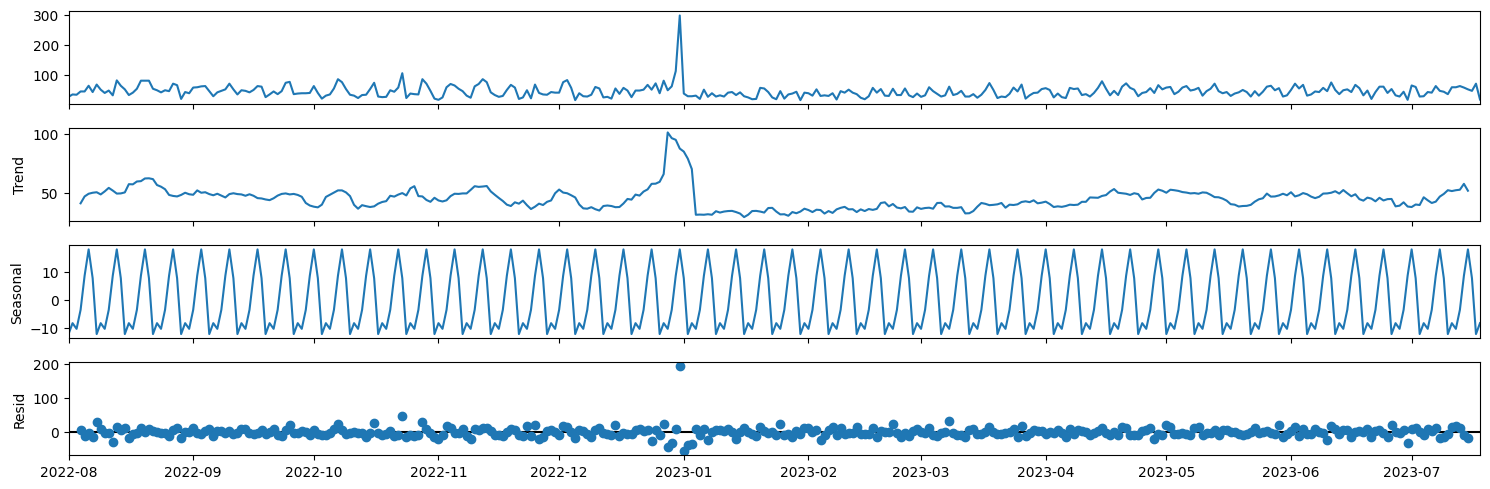

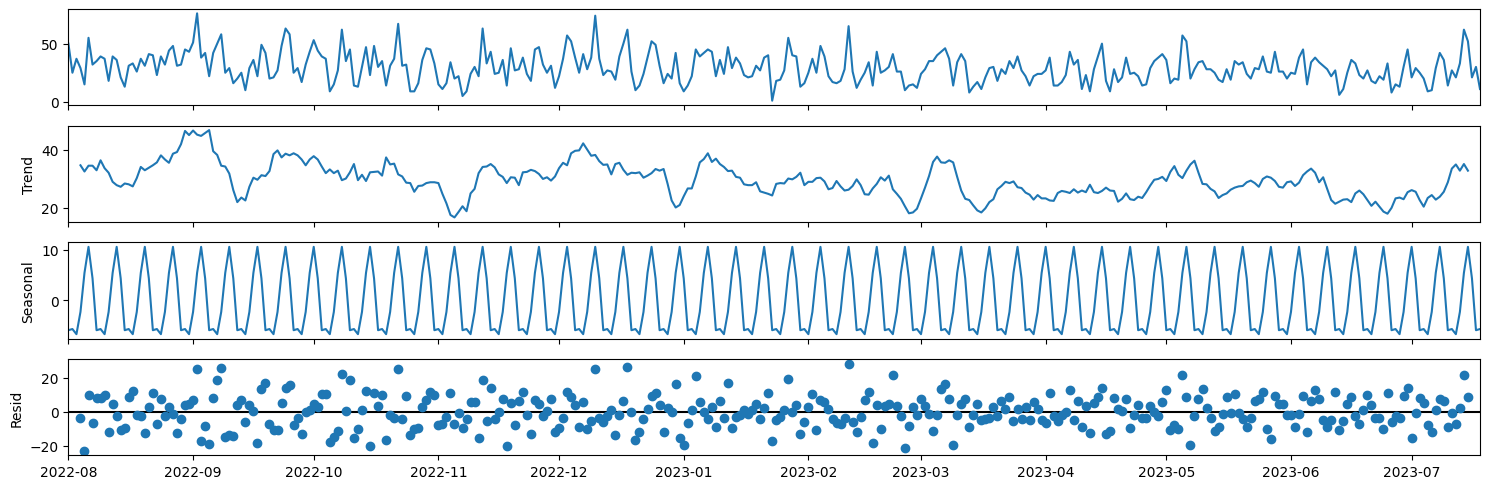

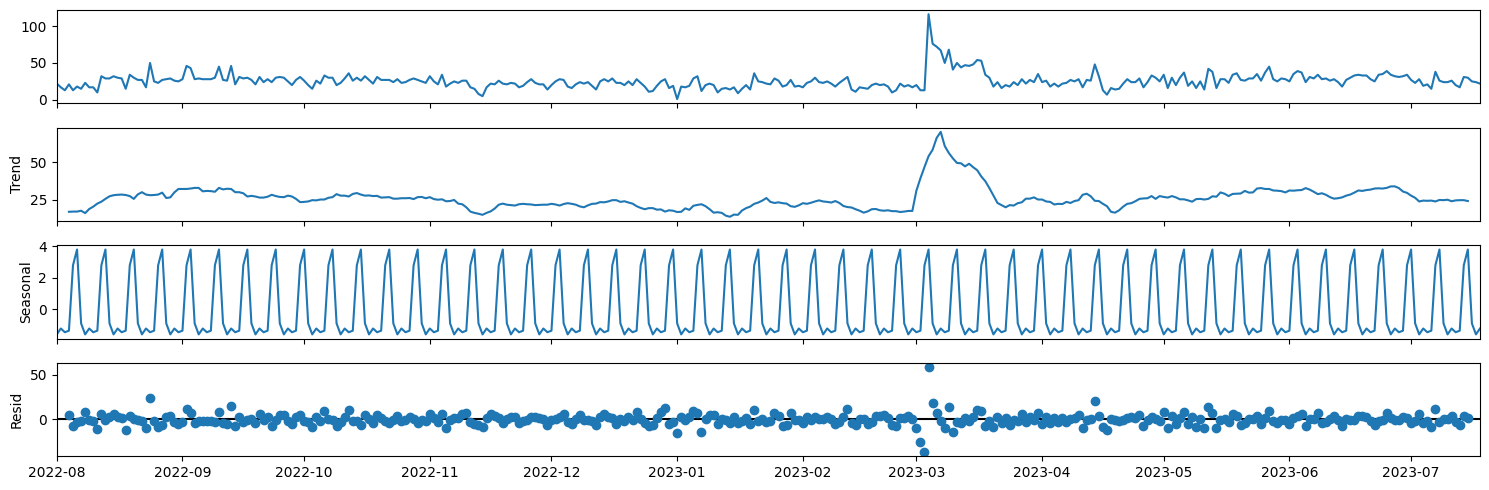

In [14]:
#раскладываем на компоненты
for key in sku_test_dict:
    ts = sku_test_dict[key].set_index('date')
    plt.rcParams["figure.figsize"] = 15, 5
    print(seasonal_decompose(ts).plot())

Отмечаем, что у всех товаров цикличность - 7 дней, что вполне ожидаемо для продуктового ритейла

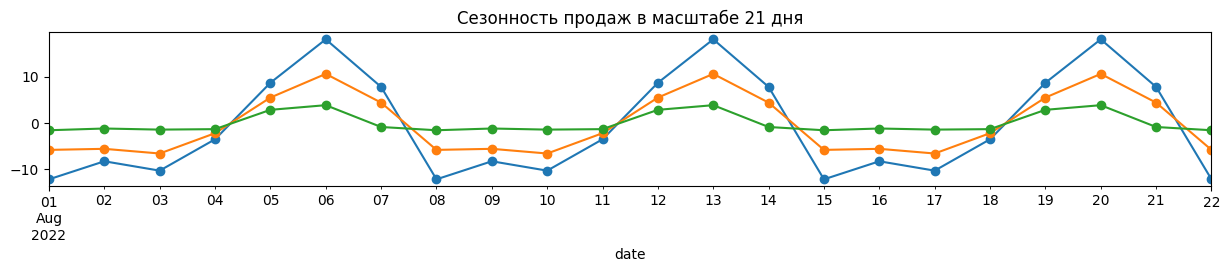

In [15]:
#ожидаемая для ритейла цикличность 7 дней
for key in sku_test_dict:
    ts = sku_test_dict[key].set_index('date')
    plt.rcParams["figure.figsize"] = 15, 2
    plt.title('Сезонность продаж в масштабе 21 дня')
    seasonal_decompose(ts).seasonal[:22].plot(marker="o")

In [16]:
#тест на стационарность
for key in sku_test_dict:
    ts = sku_test_dict[key].set_index('date')
    test = adfuller(ts)
    print (f'ADF: {test[0]}')
    print (f'p-value: {test[1]}')
    print (f'Critical values: {test[4]}')
    if test[0]> test[4]['5%']:
        print (f'(!) Временной ряд товара № {key} нестационарен')
        print ('--- --- ---')
    else:
        print (f'Временной ряд товара № {key} стационарен')
        print ('--- --- ---')

ADF: -5.251600760575891
p-value: 6.8919871074524835e-06
Critical values: {'1%': -3.4494474563375737, '5%': -2.8699542285903887, '10%': -2.5712527305187987}
Временной ряд товара № 4 стационарен
--- --- ---
ADF: -3.622780319478359
p-value: 0.005340157556292118
Critical values: {'1%': -3.449846029628477, '5%': -2.870129281376164, '10%': -2.5713460670144603}
Временной ряд товара № 8 стационарен
--- --- ---
ADF: -4.17469879882134
p-value: 0.0007269789908385599
Critical values: {'1%': -3.4494474563375737, '5%': -2.8699542285903887, '10%': -2.5712527305187987}
Временной ряд товара № 10 стационарен
--- --- ---


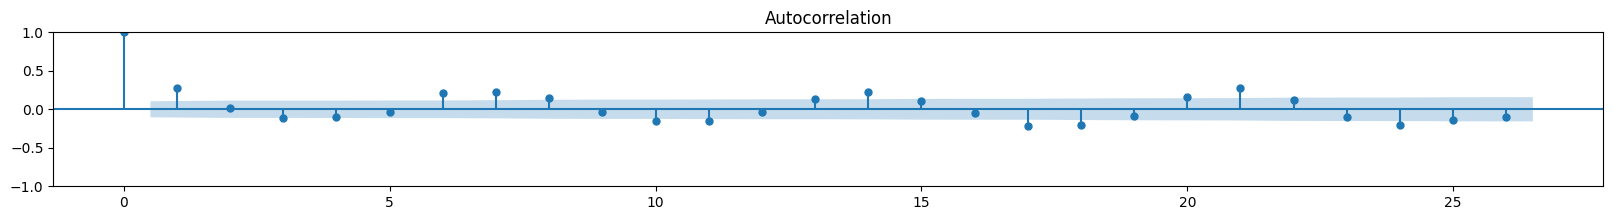

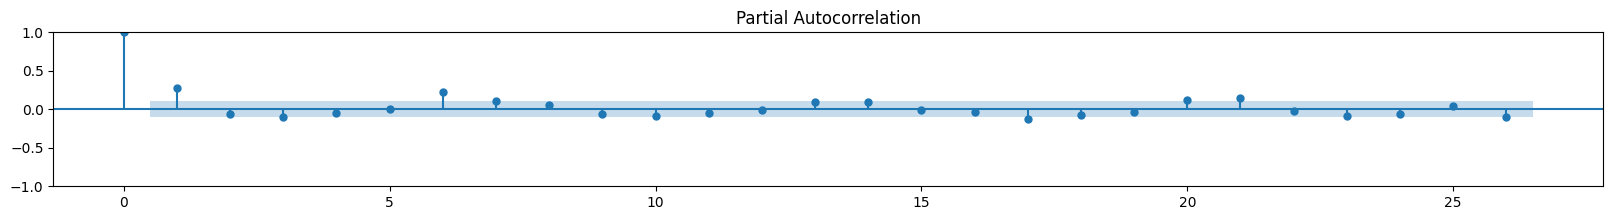

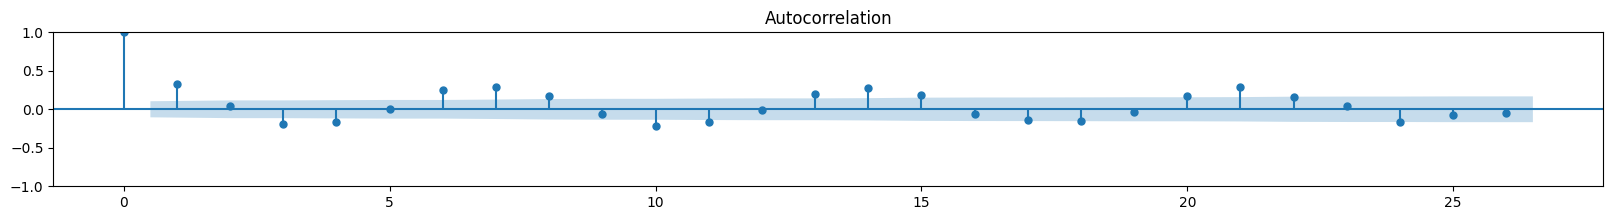

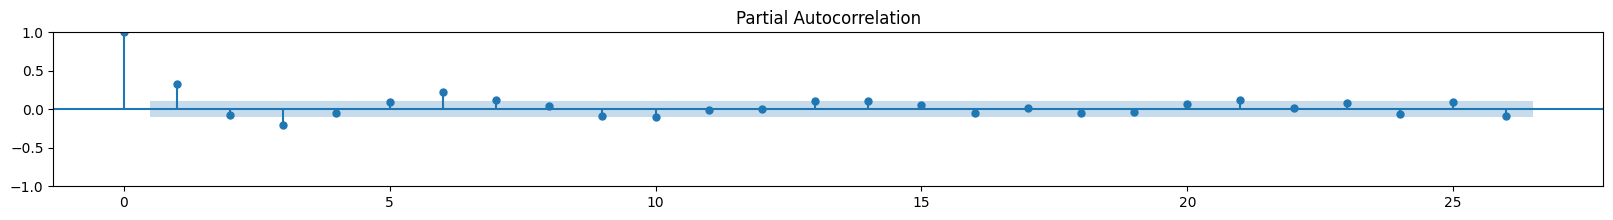

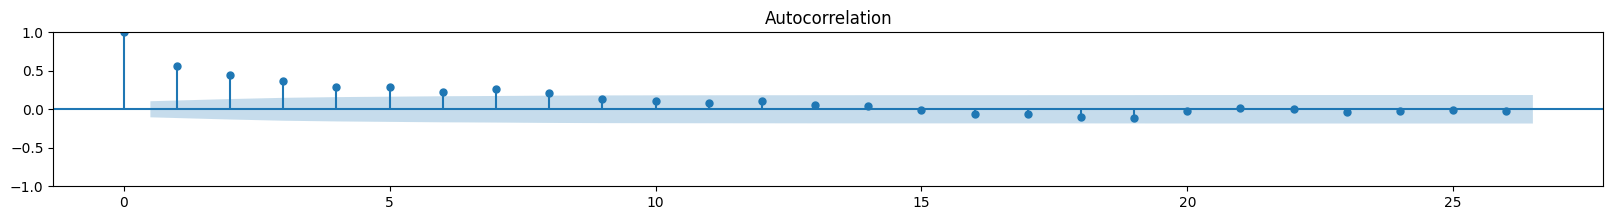

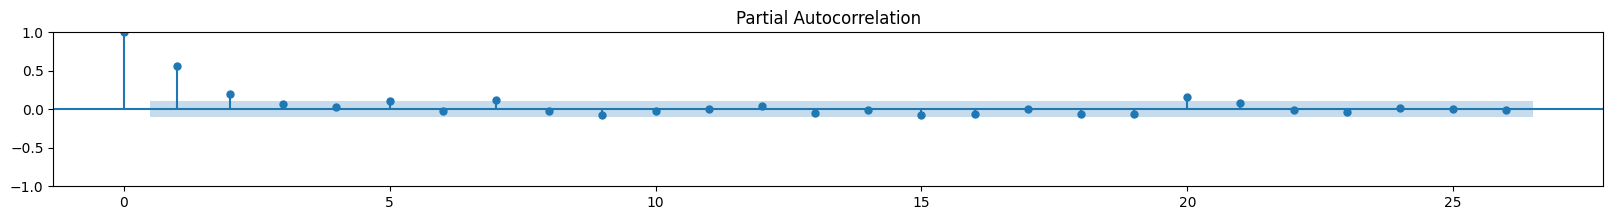

In [17]:
#графики автокорреляции
for key in sku_test_dict:
    ts = sku_test_dict[key].set_index('date')
    plt.rcParams["figure.figsize"] = 20, 2
    plot_acf(ts)
    plot_pacf(ts)

Обратим внимание, что нам могут пригодится лаги - 1, 3, 6, 7, 14

### 2.2 Naive, SeasonalNaive, ExponentialSmoothing, SeasonalWindowAverage, AutoARIMA

In [18]:
#создадим датасет с специальными именами столбцов (для библиотек), разделим на тренировочную и тестовую выборки
sf_data = df.query('pr_sku_id in @sku_test_list')[['date', 'pr_sku_id', 'pr_sales_in_units']]
sf_data = sf_data.rename(columns={'date': 'ds', 'pr_sku_id': 'unique_id', 'pr_sales_in_units': 'y'})
train = sf_data.loc[sf_data['ds'] < '2023-07-05']
test = sf_data.loc[sf_data['ds'] >= '2023-07-05']

In [19]:
#перечислим методы, которые будем использовать, запишем их в соответствующий объект библиотеки
models = [
    SeasonalNaive(season_length=7),
    Naive(),
    AutoETS(season_length=7),
    SeasonalWindowAverage(season_length=7, window_size=7),
    AutoARIMA(season_length=7),
]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,
)

In [20]:
#обучаем, прогнозируем продажи на 14 дней и записываем результаты в соответствующий датафрейм
sf.fit(train)
sf_forecast = sf.forecast(h=14)
sf_forecast_df = sf_forecast.reset_index().merge(test, how='left', on=['unique_id', 'ds'])

### 2.3 Machine Learning — Linear Regression, XGBoost, LGBM

Вспоминаем лаги из графиков автокорреляции для параметров моделей - 1, 3, 6, 7 и 14 дней.

In [21]:
#перечислим модели машинного обучения, которые будем использовать, запишем их в соответствующий объект библиотеки
ml = MLForecast(
    models=[
        LGBMRegressor(max_depth=10, verbose=-1),
        XGBRegressor(max_depth=10),
        LinearRegression()],
    freq='D',
    lags=[1, 3, 6, 7, 14],
    lag_transforms = {1:  [expanding_mean]},
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week']
)

#обучаем, прогнозируем продажи на 14 дней и записываем результаты в соответствующий датафрейм
ml.fit(train)
ml_forecast = ml.predict(horizon=14)

### 2.4 Сравнение прогнозов моделей

In [22]:
#создаем сводный датафрейм с результатами всех моделей
forecast_df = sf_forecast_df.merge(ml_forecast, how='left', on=['unique_id', 'ds'])
forecast_df = forecast_df.rename(columns={'y': 'Sales_Test'})

In [23]:
#строим графики для каждого товара и модели
columns = ['Sales_Test', 'Naive', 'SeasonalNaive', 'SeasWA', 'AutoETS', 'AutoARIMA', 'LinearRegression', 'XGBRegressor', 'LGBMRegressor']

fig1 = px.line(forecast_df.query('unique_id == 4'), x="ds", y=columns, hover_data={"ds": "|%B %d, %Y"},
               title='Товар 4: Финальное сравнение прогнозов')
fig1.update_xaxes(title=None).update_yaxes(title='Продажи товара')

fig2 = px.line(forecast_df.query('unique_id == 8'), x="ds", y=columns, hover_data={"ds": "|%B %d, %Y"},
               title='Товар 8: Финальное сравнение прогнозов')
fig2.update_xaxes(title=None).update_yaxes(title='Продажи товара')

fig3 = px.line(forecast_df.query('unique_id == 10'), x="ds", y=columns, hover_data={"ds": "|%B %d, %Y"},
               title='Товар 10: Финальное сравнение прогнозов')
fig3.update_xaxes(title=None).update_yaxes(title='Продажи товара')

fig1.show()
fig2.show()
fig3.show()

fig1.write_html("plotly/fig4.html")
fig2.write_html("plotly/fig5.html")
fig3.write_html("plotly/fig6.html")

In [24]:
#записываем все метрики и выводим в таблице
model_list = ['Naive', 'SeasonalNaive', 'SeasWA', 'AutoETS', 'AutoARIMA', 'LinearRegression', 'XGBRegressor', 'LGBMRegressor']
wape_dict = {}

for sku in sku_test_list:
    wape_dict[sku] = {}
    for model in model_list:
        y_true = forecast_df[forecast_df['unique_id'] == sku]['Sales_Test']
        y_pred = forecast_df[forecast_df['unique_id'] == sku][model]
        wape_dict[sku][model] = round(wape(y_true, y_pred), 2)

wape_df = pd.DataFrame.from_dict(wape_dict, orient='index')
wape_df.style.highlight_min(color='lightgreen', axis=1)

### 2.5 Выводы

1. На примере рассматриваемых товаров мы видим, что градинетный бустинг решающих деревьев действительно является очень эффективным инструментом для прогноза временных рядом.
2. Нужно также обязательно учесть, что мы не учитывали в моделях бустинга возможность использования множества других признаков товара. Кроме того мы не оптимизировали гиперпараметры и лишь использовали список лагов, которые увидели на графиках автокорреляции.
3. Среди неоспоримых преимуществ бустинга деревьев - возможность работы с пропусками в продажах и высокая интерпретируемость модели.
4. Опыт крупных ритейлеров показывает, что наиболее эффективные решения дает использование моделей бустинга деревьев, в частности многими компаниями используются модели LightGBM, потому что они показывают результаты не хуже, чем аналоги (например XGBM, CatBoost), при этом работают значительно быстрее.
5. Стоит также отметить и минус данного подхода. Бустинг деревьев допольно плохо работает с трендом и новыми аномалиями в продажах.
6. По итогам данного сравнения выбираем для дальнейшего использования LightGBM. Благодаря скорости, мы сможем сразу попробовать реализовать вариант обучения модели для каждого товара.

# 3. Основное решение

### 3.1 Создаем датасеты для обучения модели для каждого товара

In [25]:
df = df.set_index('date')

# признаки для удаления
cols_to_drop = ['pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']

# разделение на train и test выборки
def tt_split(data):
    X_train = data[:-14].drop('pr_sales_in_units', axis=1)
    y_train = data[:-14].pr_sales_in_units
    X_test = data[-14:].drop('pr_sales_in_units', axis=1)
    y_test = data[-14:].pr_sales_in_units
    return X_train, y_train, X_test, y_test

In [26]:
# новые фичи
def new_features(data):
    data = data.copy()

    data['dayofweek'] = data.index.dayofweek
    data['dayofyear'] = data.index.dayofyear
    data['weekofyear'] = data.index.isocalendar().week
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year - 2021

    for i in [1, 3, 6, 7, 14]:
        data['lag_' + str(i)] = data.pr_sales_in_units.shift(i)

    data = data.drop(cols_to_drop, axis=1)
    return data

In [27]:
#создаем словарь с номерами товаров в ключах и соответствующими датасетами для обучения модели в значениях
sku_list = df['pr_sku_id'].unique().tolist()
sku_df_dict = {sku: pd.DataFrame(new_features(df[df['pr_sku_id'] == sku])) for sku in sku_list}

### 3.2 Обучаем модели и проверяем результат на графике + метрика WAPE

In [28]:
# обучаем модели для каждой пары магазин-товар, оцениваем метрику WAPE
models_wape_dict = {}
for key in sku_df_dict.keys():
    X_train, y_train, X_test, y_test = tt_split(sku_df_dict[key])
    model = LGBMRegressor(random_state=42, verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    models_wape_dict[key] = round(wape(y_test, y_pred)*100, 2)

pred_wape = pd.DataFrame.from_dict(models_wape_dict, orient='index', columns=['wape']).sort_index()
pred_wape.describe()

wape
count  180.000000
mean    45.900333
std     18.338787
min     16.330000
25%     32.980000
50%     43.850000
75%     54.382500
max    129.800000

Средний показатель WAPE около 45 - неприемлем, попробуем доработать модель.

Какие sku плохо обучились на бейслайне и почему

In [29]:
pred_bad = pred_wape.query('wape > 30').index.to_list()
pred_good = pred_wape.query('wape <= 30').index.to_list()

sku_pred_bad = df.query('pr_sku_id in @pred_bad').pivot_table(values='pr_sales_in_units',
                                                    index='date', columns='pr_sku_id', aggfunc='sum').reset_index()
sku_pred_good = df.query('pr_sku_id in @pred_good').pivot_table(values='pr_sales_in_units',
                                                    index='date', columns='pr_sku_id', aggfunc='sum').reset_index()

fig1 = px.line(sku_pred_bad, x="date", y=sku_pred_bad.columns, hover_data={"date": "|%B %d, %Y"}, title=f'Плохие прогнозы: {len(pred_bad)}')
fig2 = px.line(sku_pred_good, x="date", y=sku_pred_good.columns, hover_data={"date": "|%B %d, %Y"}, title=f'Хорошие прогнозы: {len(pred_good)}')
fig1.show()
fig2.show()

fig1.write_html("plotly/fig7.html")
fig2.write_html("plotly/fig8.html")

Метрика WAPE большинства товаров слишком высокая. Это неприемлемый результат и он требует доработки.

### 3.3 Оптимизация гиперпараметров

In [30]:
#выбираем для оптимизации товар
sku_df_dict = {sku: pd.DataFrame(new_features(df[df['pr_sku_id'] == sku])) for sku in sku_list}
X_train, y_train, X_test, y_test = tt_split(sku_df_dict[8])

In [31]:
def optuna_obj(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 2000, 100)
  learning_rate = trial.suggest_categorical('learning_rate', [0.005, 0.01, 0.03, 0.05, 0.1, 0.5])

  # создаем модель
  model = LGBMRegressor(random_state=42,
                        n_estimators=n_estimators,
                        learning_rate = learning_rate,
                        verbose=-1)
  # обучаем модель
  model.fit(X_train, y_train)
  score = wape(y_test, model.predict(X_test))

  return score

In [32]:
study = optuna.create_study(study_name="LGBM", direction="minimize")
study.optimize(optuna_obj, n_trials=30)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2023-11-06 20:21:26,328] A new study created in memory with name: LGBM
[I 2023-11-06 20:21:26,589] Trial 0 finished with value: 0.3762760108148134 and parameters: {'n_estimators': 1500, 'learning_rate': 0.03}. Best is trial 0 with value: 0.3762760108148134.
[I 2023-11-06 20:21:26,648] Trial 1 finished with value: 0.3347429067122711 and parameters: {'n_estimators': 400, 'learning_rate': 0.01}. Best is trial 1 with value: 0.3347429067122711.
[I 2023-11-06 20:21:26,954] Trial 2 finished with value: 0.38182172892092314 and parameters: {'n_estimators': 1800, 'learning_rate': 0.05}. Best is trial 1 with value: 0.3347429067122711.
[I 2023-11-06 20:21:27,229] Trial 3 finished with value: 0.3769398223930443 and parameters: {'n_estimators': 1600, 'learning_rate': 0.03}. Best is trial 1 with value: 0.3347429067122711.
[I 2023-11-06 20:21:27,407] Trial 4 finished with value: 0.37547006986869175 and parameters: {'n_estimators': 1000, 'learning_rate': 0.05}. Best is trial 1 with value: 0.33474290

Наилучшие значения гиперпараметров {'n_estimators': 400, 'learning_rate': 0.01}


In [33]:
# обучаем модели для каждой пары магазин-товар, оцениваем метрику WAPE
models_wape_dict = {}
for key in sku_df_dict.keys():
    X_train, y_train, X_test, y_test = tt_split(sku_df_dict[key])
    model = LGBMRegressor(random_state=42, verbose=-1,
                          n_estimators=900, learning_rate=0.005)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    models_wape_dict[key] = round(wape(y_test, y_pred)*100, 2)

pred_wape = pd.DataFrame.from_dict(models_wape_dict, orient='index', columns=['wape']).sort_index()
pred_wape.describe()

wape
count  180.000000
mean    43.633444
std     17.455795
min     16.090000
25%     33.392500
50%     41.630000
75%     51.300000
max    132.190000

Благодаря оптимизации двух параметров - количества деревьев и скорости обучения - удалось немного снизить среднее заначение метрики. Но этого не достаточно.

### 3.4 Работа с фичами

Попробуем расширить набор дополнительных признаков.

In [34]:
# новые фичи
def new_features_2(data):
    data = data.copy()

    # time-based features
    data['dayofweek'] = data.index.dayofweek
    data['dayofmonth'] = data.index.day
    data['dayofyear'] = data.index.dayofyear
    data['weekofyear'] = data.index.isocalendar().week
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year - 2021

    # lag features
    for i in [1, 3, 6, 7, 14]:
        data['lag_' + str(i)] = data.pr_sales_in_units.shift(i)
    for i in [1, 3, 6, 7, 14]:
        data['diff_' + str(i)] = data.pr_sales_in_units.diff(periods=i)
    for i in [7, 14, 28]:
        data['lag_' + str(i) + '_mean'] = data.pr_sales_in_units.shift(i).rolling(window=7).mean()

    # удаляем ненужные столбцы и первые строки с пропусками
    data = data.drop(cols_to_drop, axis=1)
    return data

In [35]:
#создаем словарь с номерами товаров в ключах и соответствующими датасетами для обучения модели в значениях
sku_list = df['pr_sku_id'].unique().tolist()
sku_df_dict = {sku: pd.DataFrame(new_features_2(df[df['pr_sku_id'] == sku])) for sku in sku_list}

In [36]:
# обучаем модели для каждой пары магазин-товар, вывод графика и метрики WAPE
models_wape_dict = {}
models_dict = {}
for key in sku_df_dict.keys():
    X_train, y_train, X_test, y_test = tt_split(sku_df_dict[key])
    model = LGBMRegressor(random_state=42, verbose=-1,
                          n_estimators=900, learning_rate=0.005)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    models_wape_dict[key] = round(wape(y_test, y_pred)*100, 2)
    models_dict[key] = model

pred_wape = pd.DataFrame.from_dict(models_wape_dict, orient='index', columns=['wape']).sort_index()
pred_wape.describe()

wape
count  180.000000
mean    11.269611
std      5.306657
min      3.080000
25%      7.830000
50%     10.290000
75%     13.912500
max     31.820000

In [37]:
pred_bad = pred_wape.query('wape > 30').index.to_list()
pred_good = pred_wape.query('wape <= 30').index.to_list()

sku_pred_bad = df.query('pr_sku_id in @pred_bad').pivot_table(values='pr_sales_in_units',
                                                    index='date', columns='pr_sku_id', aggfunc='sum').reset_index()
sku_pred_good = df.query('pr_sku_id in @pred_good').pivot_table(values='pr_sales_in_units',
                                                    index='date', columns='pr_sku_id', aggfunc='sum').reset_index()

fig1 = px.line(sku_pred_bad, x="date", y=sku_pred_bad.columns, hover_data={"date": "|%B %d, %Y"}, title=f'Плохие прогнозы: {len(pred_bad)}')
fig2 = px.line(sku_pred_good, x="date", y=sku_pred_good.columns, hover_data={"date": "|%B %d, %Y"}, title=f'Хорошие прогнозы: {len(pred_good)}')
fig1.show()
fig2.show()

fig1.write_html("plotly/fig9.html")
fig2.write_html("plotly/fig10.html")

1. Модель градиентного бустинга деревьев предоставляет большие возможности при работе с временными рядами. Мы можем генерировать большое количество дополнительных признаков, в том числе из внешних источников (прогноз погоды, курс валют, инфляция и т.п.).
2. В случае работы с новыми товарами, не имеющими данных о продажах, мы можем обучить модель на похожих товарах - из одной категории или путем предварительной кластеризации временных рядов продаж товаров.
3. Дальнейшее улучшение данного проекта подразумевает работу с дополнительными признаками. Их создание требует в том числе дополнительной информации от заказчика - что это за товары, к какой ктегории относятся и пр.

### 3.5 Сериализация и сохранение моделей

In [38]:
# производим сериализацию и записываем модели в формате pkl в папку models, в имени указываем соответствующий номер sku
for key in models_dict:
    pickle.dump(models_dict[key], open('models/'+str(key)+'_model.pkl', 'wb'))